In [2]:
from scipy.stats import randint, uniform
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.compose import make_column_selector, ColumnTransformer
import random
random.seed(101)
np.random.seed(101)

In [3]:
import pandas as pd
import numpy as np
X = pd.read_csv("https://raw.githubusercontent.com/kozaka93/2023Z-MachineLearning/main/project/artifical_train_data.csv")
y = pd.read_csv("https://raw.githubusercontent.com/kozaka93/2023Z-MachineLearning/main/project/artifical_train_labels.csv").values.ravel()
real_test = pd.read_csv("https://raw.githubusercontent.com/kozaka93/2023Z-MachineLearning/main/project/artifical_test_data.csv")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

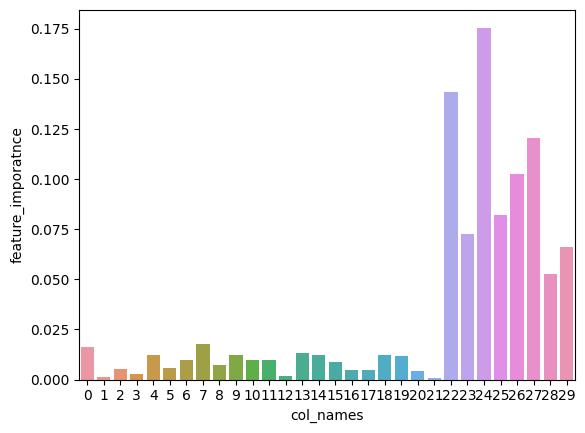

In [4]:
gb = GradientBoostingClassifier().fit(X_train, y_train)

df = pd.DataFrame({
    "col_names": gb.feature_names_in_,
    "feature_imporatnce": gb.feature_importances_})
sns.barplot(df, x="col_names", y = "feature_imporatnce")
gb_cols = list(df[df["feature_imporatnce"] > 0.02].col_names)

In [14]:
gb_params = {
    'random_state':100,
    'learning_rate': 2,
 'loss': 'exponential',
 'min_samples_split': 3,
 'n_estimators': 500}
gb = GradientBoostingClassifier(**gb_params)

rf_params = {
    'random_state':100,
    'n_estimators': 110,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_depth': 16,
 'criterion': 'gini'}
rforest1 = RandomForestClassifier(**rf_params)

rf2_params = {
    'random_state':100,
 'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_depth': 5,
 'criterion': 'entropy'
}
rforest2 = RandomForestClassifier(**rf2_params)

params_knn = {'n_neighbors': 5, 'p': 2}
knn = KNeighborsClassifier(**params_knn)
pipeline_ensembels = Pipeline([
    ("selector", ColumnTransformer([
        ("selector", "passthrough", gb_cols)
    ], remainder="drop")),
    ('scaler', StandardScaler()),
    ('stack', StackingClassifier(estimators=[("rf1", rforest1),
                                             ("rf2", rforest2),
                                             ('knn', knn),
                                             ("gb", gb)]))
])


In [13]:
params = {
    'stack__rf2__n_estimators': [70, 80,90,95, 100,110, 120,130, 150, 200, 400, 600, 900, 1000, 2000, 4000],
    'stack__rf2__max_depth': [1, 2, 3, 5, 8, 10, 12, 13, 15, 16, 18],
    'stack__rf2__min_samples_split': [6, 8,10,15, 20, 25, 40, 50, 70, 100],
    'stack__rf2__min_samples_leaf': [2, 3, 5, 8, 10, 11, 12 ,15, 20],
    'stack__rf2__criterion': ['entropy', 'gini'],
    "stack__knn__n_neighbors": randint(3, 100),
    "stack__knn__p": randint(1, 4),
} 
stack_opt = RandomizedSearchCV(pipeline_ensembels,
                            scoring="balanced_accuracy",
                            n_iter= 200,
                            cv = 3,
                            n_jobs=3,
                            verbose=2,
                            return_train_score = True,
                            param_distributions= params).fit(X, y)

print(stack_opt.best_score_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
0.866974759190328


In [14]:
stack_opt.best_params_

{'stack__knn__n_neighbors': 6,
 'stack__knn__p': 2,
 'stack__rf2__criterion': 'gini',
 'stack__rf2__max_depth': 3,
 'stack__rf2__min_samples_leaf': 2,
 'stack__rf2__min_samples_split': 6,
 'stack__rf2__n_estimators': 130}

SPRAWDZAM CZY ZMINIEJSZENIE OBSZARU SZUKANIA n_neighbors DO CYFR POLEPSZY WYNIK.

In [15]:
params = {
    'stack__rf2__n_estimators': [70, 80,90,95, 100,110, 120,130, 150, 200, 400, 600, 900, 1000],
    'stack__rf2__max_depth': [1, 2, 3, 5, 8, 10, 12, 13, 15, 16, 18],
    'stack__rf2__min_samples_split': [6, 8,10,15, 20, 25, 40, 50, 70, 100],
    'stack__rf2__min_samples_leaf': [2, 3, 5, 8, 10, 11, 12 ,15, 20],
    'stack__rf2__criterion': ['entropy', 'gini'],
    "stack__knn__n_neighbors": randint(3, 10), # jedyna zmiana
    "stack__knn__p": randint(1, 4),
} 
stack_opt = RandomizedSearchCV(pipeline_ensembels,
                            scoring="balanced_accuracy",
                            n_iter= 200,
                            cv = 3,
                            n_jobs=3,
                            verbose=2,
                            return_train_score = True,
                            param_distributions= params).fit(X, y)

print(stack_opt.best_score_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
0.869971768175361


In [17]:
stack_opt.best_params_

{'stack__knn__n_neighbors': 8,
 'stack__knn__p': 1,
 'stack__rf2__criterion': 'gini',
 'stack__rf2__max_depth': 13,
 'stack__rf2__min_samples_leaf': 15,
 'stack__rf2__min_samples_split': 100,
 'stack__rf2__n_estimators': 200}

In [13]:
stack_opt.best_estimator_

NameError: name 'stack_opt' is not defined

Zostawiam - ostateczny wynik satysfakcjonujący

In [5]:
gb_params = {
    'random_state':100,
    'learning_rate': 2,
 'loss': 'exponential',
 'min_samples_split': 3,
 'n_estimators': 500}
gb = GradientBoostingClassifier(**gb_params)

rf_params = {
    'random_state':100,
    'n_estimators': 110,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_depth': 16,
 'criterion': 'gini'}
rforest1 = RandomForestClassifier(**rf_params)

rf2_params = {
    'random_state':100,
 'n_estimators': 200,
 'min_samples_split': 100,
 'min_samples_leaf': 15,
 'max_depth': 13,
 'criterion': 'gini'
}
rforest2 = RandomForestClassifier(**rf2_params)

params_knn = {'n_neighbors': 8, 'p': 1}
knn = KNeighborsClassifier(**params_knn)
final_model = Pipeline([
    ("selector", ColumnTransformer([
        ("selector", "passthrough", gb_cols)
    ], remainder="drop")),
    ('scaler', StandardScaler()),
    ('stack', StackingClassifier(estimators=[("rf1", rforest1),
                                             ("rf2", rforest2),
                                             ('knn', knn),
                                             ("gb", gb)]))
]).fit(X, y)


In [6]:
np.savetxt("320543_artifical_prediction.txt", final_model.predict_proba(real_test)[:, 1], header = "320543")

DALSZY KOD NIE JEST WYKORZYSTANY DO WYTWORZENIA ROZWIĄZANIA - BYŁY TO TYLKO NIEUDANE PRÓBY.

In [19]:
''' SPRAWDZENIE CZY DRUGI RANDOM FOREST COŚ DAJE GDY OPTYMALIZUJEMY HIPERPARAMENTRY NA SAMYM TRAINIE - DAJE'''
gb_params = {
    'random_state':100,
    'learning_rate': 2,
 'loss': 'exponential',
 'min_samples_split': 3,
 'n_estimators': 500}
gb = GradientBoostingClassifier(**gb_params)

rf_params = {
    'random_state':100,
    'n_estimators': 110,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_depth': 16,
 'criterion': 'gini'}
rforest1 = RandomForestClassifier(**rf_params)

params_knn = {'n_neighbors': 5, 'p': 2}
knn = KNeighborsClassifier(**params_knn)
pipeline_ensembels = Pipeline([
    ("selector", ColumnTransformer([
        ("selector", "passthrough", gb_cols)
    ], remainder="drop")),
    ('scaler', StandardScaler()),
    ('stack', StackingClassifier(estimators=[("rf1", rforest1),
                                             ('knn', knn),
                                             ("gb", gb)]))
]).fit(X_train, y_train)
y_pred_test = pipeline_ensembels.predict(X_test)
params_knn = {'n_neighbors': 8, 'p': 1}
knn = KNeighborsClassifier(**params_knn)
pipeline_ensembels = Pipeline([
    ("selector", ColumnTransformer([
        ("selector", "passthrough", gb_cols)
    ], remainder="drop")),
    ('scaler', StandardScaler()),
    ('stack', StackingClassifier(estimators=[("rf1", rforest1),
                                             ('knn', knn),
                                             ("gb", gb)]))
]).fit(X_train, y_train)
y_pred_test2 = pipeline_ensembels.predict(X_test)
print("knn, k=5, p=2", balanced_accuracy_score(y_test, y_pred_test))
print("knn, k=8, p=1", balanced_accuracy_score(y_test, y_pred_test2))

knn, k=5, p=2 0.8766556567577486
knn, k=8, p=1 0.873719681046275


In [24]:
''' SPRAWDZENIE CZY DRUGI RANDOM FOREST COŚ DAJE - DAJE, WYNIK TROCHĘ LEPSZY'''
pipeline_ensembels = Pipeline([
    ("selector", ColumnTransformer([
        ("selector", "passthrough", gb_cols)
    ], remainder="drop")),
    ('scaler', StandardScaler()),
    ('stack', StackingClassifier(estimators=[("rf1", rforest1),
                                             ('knn', knn),
                                             ("gb", gb)]))
])
params = {
    "stack__knn__n_neighbors": randint(3, 10),
    "stack__knn__p": randint(1, 4),
} 
stack_opt2 = RandomizedSearchCV(pipeline_ensembels,
                            scoring="balanced_accuracy",
                            n_iter= 25,
                            cv = 3,
                            n_jobs=3,
                            verbose=2,
                            return_train_score = True,
                            param_distributions= params).fit(X, y)

print(stack_opt2.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
0.86396276516037


In [25]:
stack_opt2.best_params_ #0.863 - gdy n_iter=25


{'stack__knn__n_neighbors': 5, 'stack__knn__p': 3}

In [23]:
stack_opt2.best_params_ #0.84 - gdy n_iter=10

{'stack__knn__n_neighbors': 9, 'stack__knn__p': 2}

In [15]:
gb_params = {
    'random_state':100,
    'learning_rate': 2,
 'loss': 'exponential',
 'min_samples_split': 3,
 'n_estimators': 500}
gb = GradientBoostingClassifier(**gb_params)

rf_params = {
    'random_state':100,
    'n_estimators': 110,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_depth': 16,
 'criterion': 'gini'}
rforest1 = RandomForestClassifier(**rf_params)

rf2_params = {
    'random_state':100,
 'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_depth': 5,
 'criterion': 'entropy'
}
rforest2 = RandomForestClassifier(**rf2_params)

params_knn = {'n_neighbors': 8, 'p': 1}
knn = KNeighborsClassifier(**params_knn)
pipeline_ensembels = Pipeline([
    ("selector", ColumnTransformer([
        ("selector", "passthrough", gb_cols)
    ], remainder="drop")),
    ('scaler', StandardScaler()),
    ('stack', StackingClassifier(estimators=[("rf1", rforest1),
                                             ("rf2", rforest2),
                                             ('knn', knn),
                                             ("gb", gb)]))
])


In [17]:
params = {
    'stack__rf2__n_estimators': [200],
    'stack__rf2__max_depth': [13],
    'stack__rf2__min_samples_split': [100],
    'stack__rf2__min_samples_leaf': [15],
    'stack__rf2__criterion': ['gini']
} 
stack_opt = RandomizedSearchCV(pipeline_ensembels,
                            scoring="balanced_accuracy",
                            n_iter= 1,
                            cv = 3,
                            n_jobs=3,
                            verbose=2,
                            return_train_score = True,
                            param_distributions= params).fit(X, y)

stack_opt.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['22', '23', '24', '25', '26',
                                                   '27', '28', '29'])])),
                ('scaler', StandardScaler()),
                ('stack',
                 StackingClassifier(estimators=[('rf1',
                                                 RandomForestClassifier(max_depth=16,
                                                                        min_samples_leaf=3,
                                                                        min_samples_split=8,
                                                                        n_estimators=110,
                                                                        random_state=100)),
                                                ('rf2',
                                                 RandomForestClassifier(max_depth=13,
                                                                        min_samples_leaf=15,
                                                                        min_samples_split=100,
                                                                        n_estimators=200,
                                                                        random_state=100)),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=8,
                                                                      p=1)),
                                                ('gb',
                                                 GradientBoostingClassifier(learning_rate=2,
                                                                            loss='exponential',
                                                                            min_samples_split=3,
                                                                            n_estimators=500,
                                                                            random_state=100))]))])